# Second order k-essence vs k-evolution

In [11]:
import numpy as np
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from pylab import rcParams
import scipy.integrate as integrate
import h5py
from mayavi import mlab

# from readgadget import *
# from pygadgetreader import *
ColorsI = ["red","blue","green","purple","darkcyan","gold","maroon","black","darkslategrey",
           "darkgreen","navy","indigo","magenta","salmon","dodgerblue","springgreen","plum",
           "cyan","khaki","lightcoral","gray"]
ColorsII = []

NUM_COLORS = 20
from matplotlib.colors import LogNorm

cm = plt.get_cmap('gist_rainbow')
# plt.style.use('seaborn-paper')
plt.rcParams['font.serif'] = 'Ubuntu'
from matplotlib import colors, ticker, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict



# Nested dictionary

In [9]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
snaps = nested_dict(2, list)

gev_snap = nested_dict(2, list)
max_secder = nested_dict(2, list)

## Background

In [10]:
As=2.215*1.e-9;
h=0.67556;
kp=0.05/h; 
ns=0.9619;
cs2_e3=1.e-7;
c=2.99792458*1.e5; #Km/s
Boxsize=300.;
# c_gev=2997.92458; #[100km/s]
H0_conf_Gev=0.11117550483538947#np.sqrt(Boxsize**2/c**2); #0.10677 rho_crit in Gev=1
# we obtain 0.11 from gevolution!

# H0=100*h/c; #H0 in 1/Mpc unit. 0.00022593979933110373
# print("H0[1/Mpc]=100h/c: ",H0);
w=-0.9;
# print("H0[1/Mpc]=100h/c: ",H0);
def Hubble_conf_Mpc(a):
    c=2.99792458*1.e5;h=0.67556;H0=100*h/c;w=-0.9;
    Omega_b=0.022032/h/h; Omega_cdm=0.12038/h/h;
    Omega_m=Omega_b+Omega_cdm; Omega_Lambda=0;
    Omega_rad=9.1671353942930788e-05; Omega_kessence=1.-Omega_m-Omega_rad;
    return H0_conf_Gev*np.sqrt(Omega_m*(a**-3)+Omega_rad*(a**-4)+Omega_kessence*(a**(-3*(1+w))))
Omega_b=0.022032/h/h; Omega_cdm=0.12038/h/h;
Omega_m=Omega_b + Omega_cdm;

#  Loading HDF5 files for pi and zeta + the Blowup snapshots

In [12]:
direct = './L_100_N_64_cs2_em4_det/'
# snap_info = np.loadtxt(direct+"/snapshots.txt")
snap_info2 = np.loadtxt(direct+"/snapshots_2.txt")


# redshifts = snap_info[:,1]
redshifts2 = snap_info2[:,1]


# for i in range(1,np.shape(redshifts)[0]):
#     snaps['Det'][str(i)]= h5py.File(direct+'/Det_kinetic'+str(i)+'.h5', "r");
#     snaps['Det'][str(i)]=snaps['Det'][str(i)]['data']
    
#     snaps['pi_k'][str(i)]= h5py.File(direct+'/pi_k'+str(i)+'.h5', "r")
#     snaps['pi_k'][str(i)]=snaps['pi_k'][str(i)]['data']
    
for i in range(1,np.shape(redshifts2)[0]):
    z_express = "z="+str(redshifts2[i])
    snaps['Det'][str(i)]= h5py.File(direct+'/Det_kinetic_num_'+str(i)+'.h5', "r");
    snaps['Det'][str(i)]=snaps['Det'][str(i)]['data']
    
    snaps['pi_k'][str(i)]= h5py.File(direct+'/pi_k_num_'+str(i)+'.h5', "r")
    snaps['pi_k'][str(i)]=snaps['pi_k'][str(i)]['data']
    


# Simulations settings:

In [13]:
Boxsize = 100;
Ngrid = 64;

### Some tests:

In [28]:
snaps['phi']['2']
np.shape(snaps['phi'][str(i)])
# snaps['Det'][str(3)][:,1,:]

(64, 64, 64)

# Finding the maximum of second derivative or the min of potential

In [17]:
i=1;
s = snaps['pi_k'][str(i)]
secder_x=np.zeros((np.shape(s)[0],np.shape(s)[1],np.shape(s)[2]))
secder_y=np.zeros((np.shape(s)[0],np.shape(s)[1],np.shape(s)[2]))
secder_z=np.zeros((np.shape(s)[0],np.shape(s)[1],np.shape(s)[2]))

for x in range(np.shape(s)[0]):
    for y in range(np.shape(s)[1]):
        secder_z[x,y,:]=np.roll(s[x,y,:],1)+np.roll(s[x,y,:],-1)-2.*s[x,y,:]
for y in range(np.shape(s)[1]):
    for z in range(np.shape(s)[2]):
        secder_x[:,y,z]=np.roll(s[:,y,z],1)+np.roll(s[:,y,z],-1)-2.*s[:,y,z]
for x in range(np.shape(s)[0]):
    for z in range(np.shape(s)[2]):
        secder_y[x,:,z]=np.roll(s[x,:,z],1)+np.roll(s[x,:,z],-1)-2.*s[x,:,z]        

np.shape(secder_y)
#secder_y is D^\pi/dy^2 at each point (x,y,z)!
#If we want it at (1,2,4) we have to ask for secder_y(1,2,4)
# np.max(secder_x[:][1][1]+secder_y[1][:][1]+secder_x[1][1][:])
maximum=np.zeros((1,3))
max_sec=0
for x in range(np.shape(s)[0]):
    for y in range(np.shape(s)[1]):
        for z in range(np.shape(s)[2]):
            if(max_sec>=secder_x[x,y,z]+secder_y[x,y,z]+secder_z[x,y,z]): # Maximum second derivative d^2_x, d^2_y and d^2z
                maximum=(x,y,z);
                max_sec=secder_x[x,y,z]+secder_y[x,y,z]+secder_z[x,y,z]
            else:
                max_sec=max_sec;

max_secder['pos'][str(i)] = maximum
max_secder['value'][str(i)] = max_sec

#     print("maximum second derivative point:",maximum)
print("Position:", max_secder['pos'][str(i)],"minimum second derivative of scalr field:",max_secder['value'][str(i)])
    

('Position:', (37, 62, 42), 'minimum second derivative of scalr field:', -1.2416159935578356e-06)


In [18]:
max_secder['pos'][str(1)]

(37, 62, 42)

In [15]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(10,10))
# ax = plt.axes(projection='3d')
# i=1

# name = r"$N_{grid} = 64^3$, p= ("+str(max_secder['pos'][str(i)][0]/Ngrid*Boxsize) + ", " + str(max_secder['pos'][str(i)][1]/Ngrid*Boxsize) +", " + str(max_secder['pos'][str(i)][2]/64.*300.)+")"
# # name_32 =  r"$N_{grid} = 128^3 $, p= ("+str(max_matrix_32[0][0]/128.*300.) + ", " + str(max_matrix_32[0][1]/128.*300.) +", " + str(max_matrix_32[0][2]/128.*300.)+")"
# # name_64 =  r"$N_{grid} = 256^3, $ p= ("+str(max_matrix_64[0][0]/256.*300.) + ", " + str(max_matrix_64[0][1]/256.*300.) +", " + str(max_matrix_64[0][2]/256.*300.)+")"

# ax.scatter(max_secder['pos'][str(i)][0]/Ngrid*Boxsize, max_secder['pos'][str(i)][1]/Ngrid*Boxsize, max_secder['pos'][str(i)][2]/Ngrid*Boxsize, color="green", linewidth=20 ,label = name);
# # ax.scatter(max_matrix_32[0][0]/128.*300., max_matrix_32[0][1]/128.*300., max_matrix_32[0][2]/128.*300.,color="red", linewidth=20,label = name_32);
# # ax.scatter(max_matrix_64[0][0]/256.*300., max_matrix_64[0][1]/256.*300., max_matrix_64[0][2]/256.*300.,color="blue", linewidth=20,label = name_64);


# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# # ax.set_zlim(-100, 100)

# ax.view_init(10, 45)
# plt.legend(fontsize=16)



# Illustration

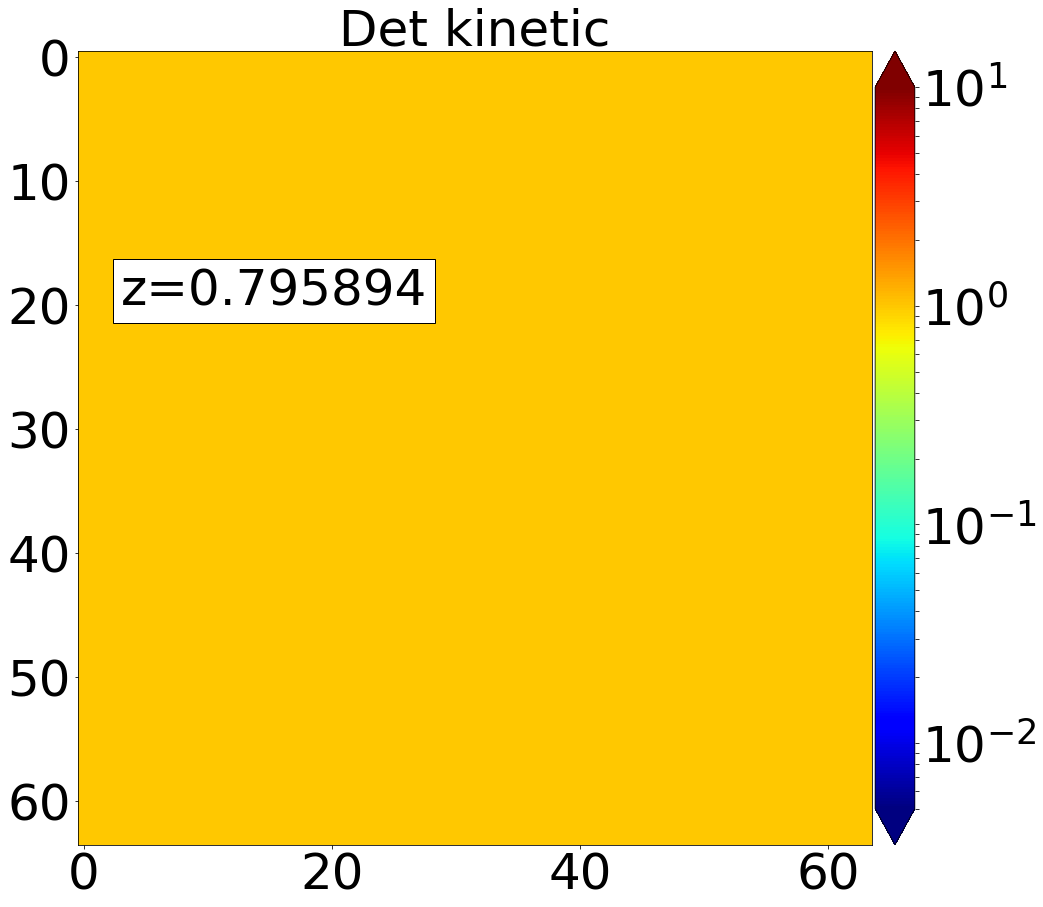

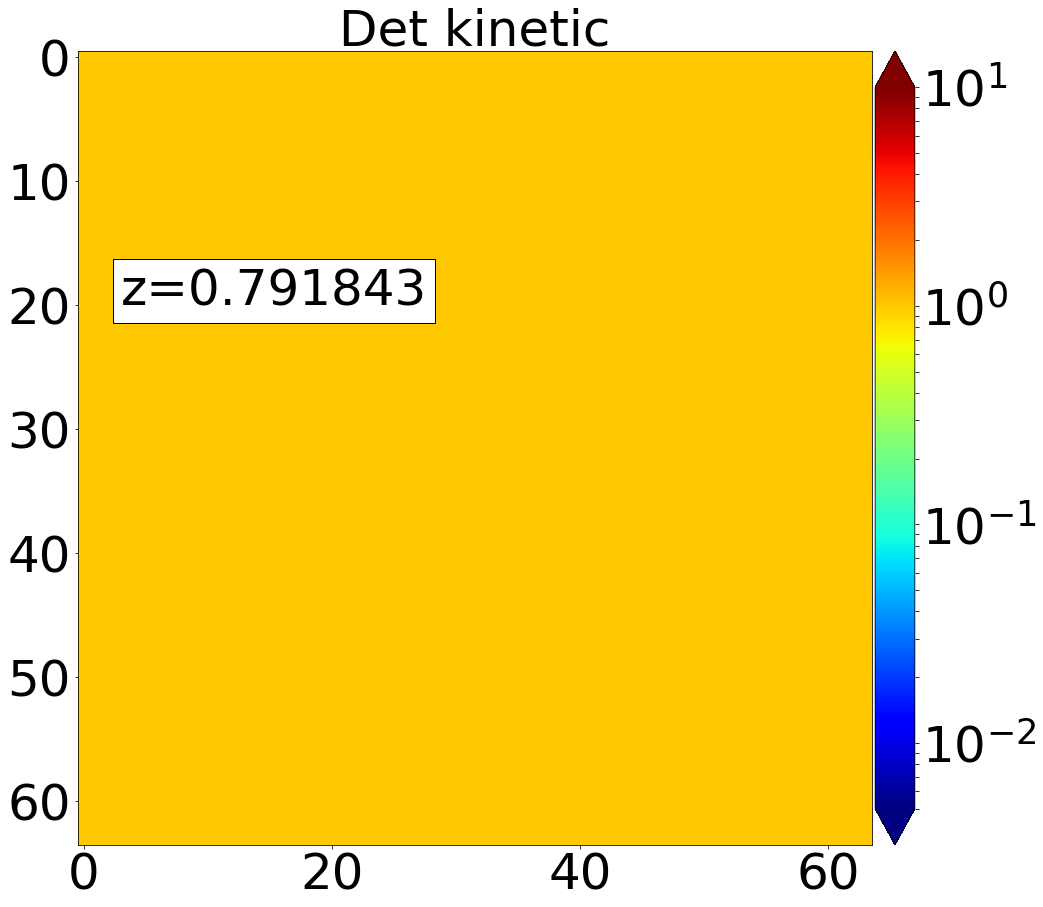

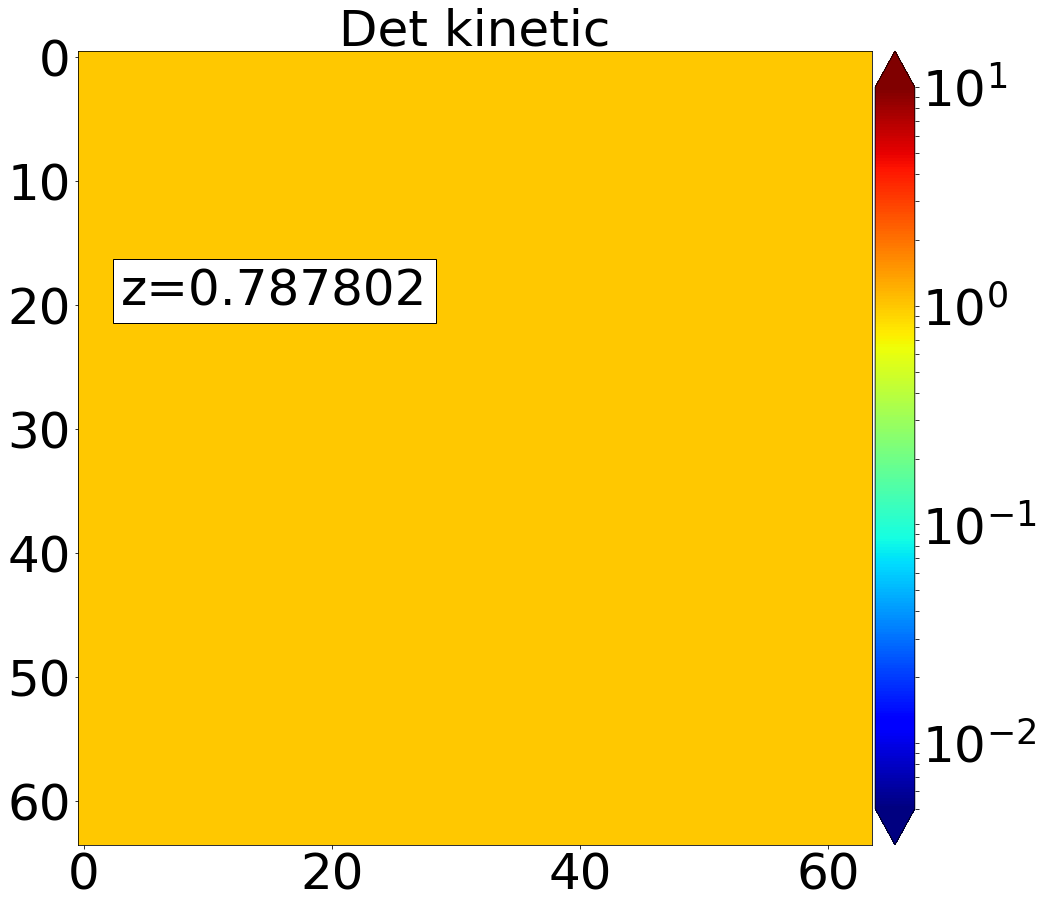

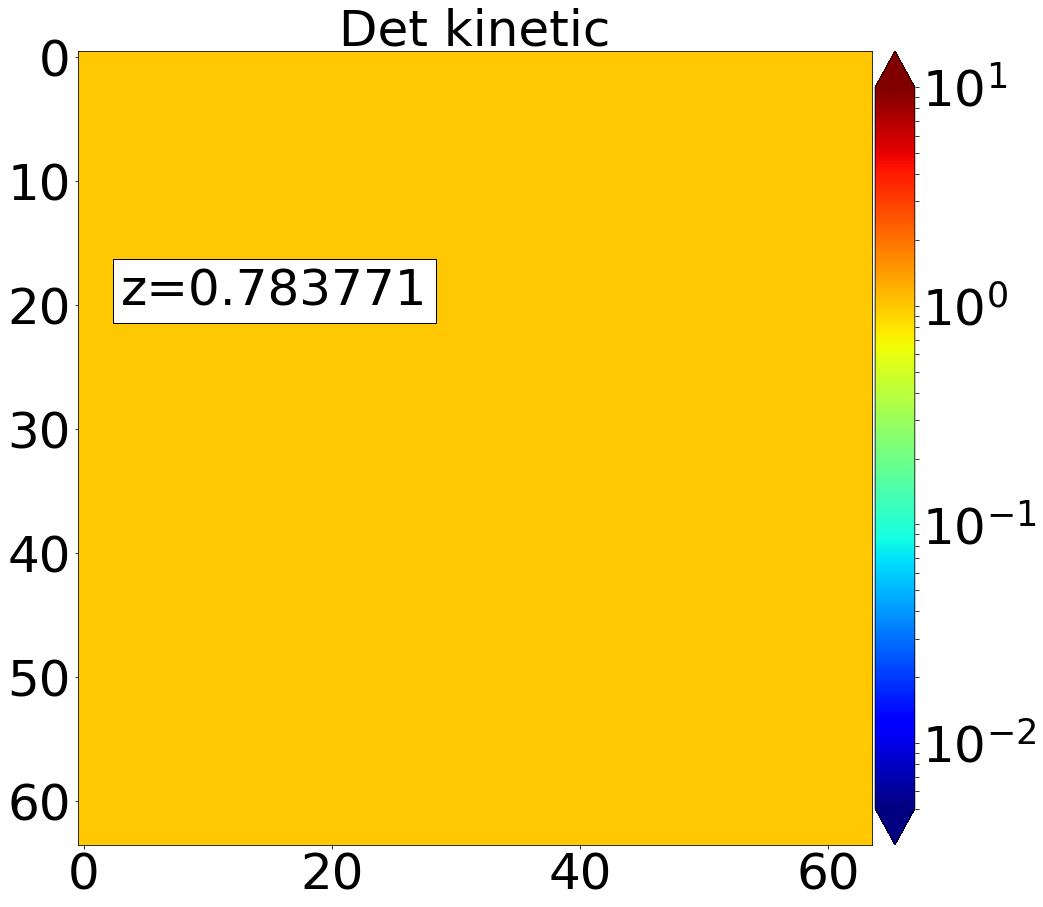

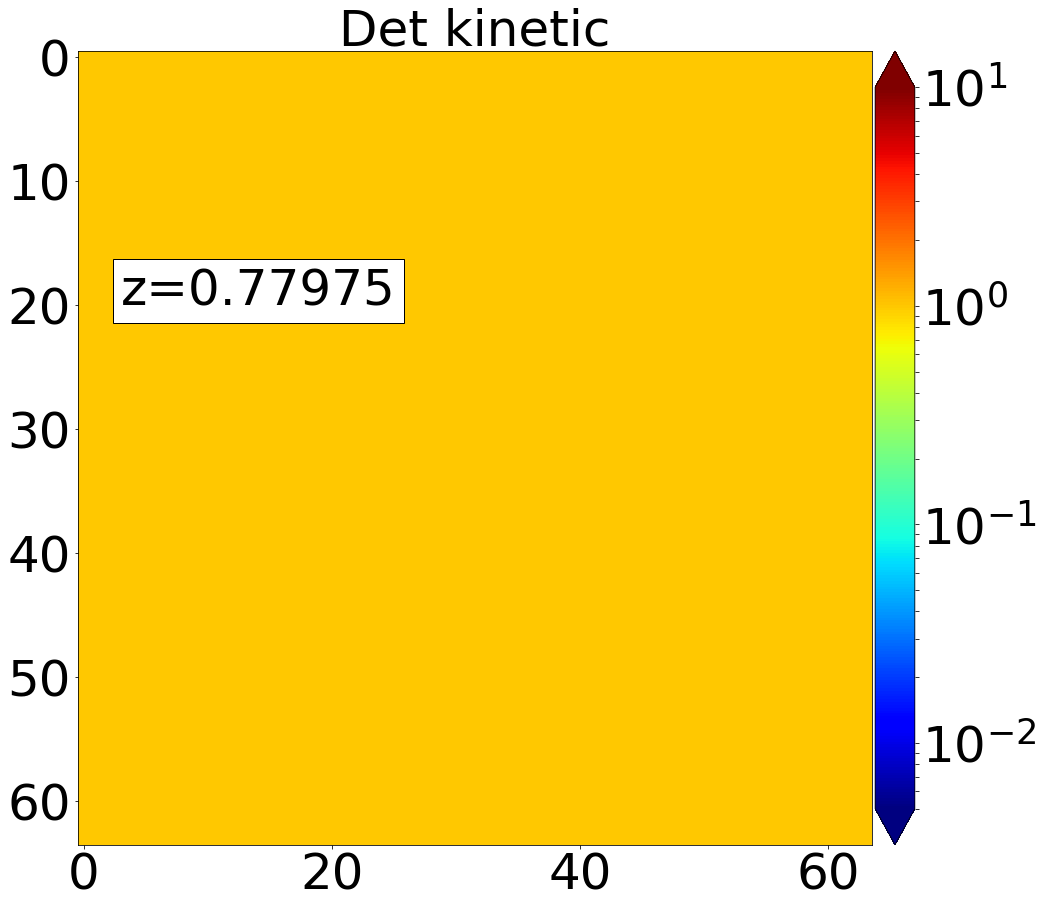

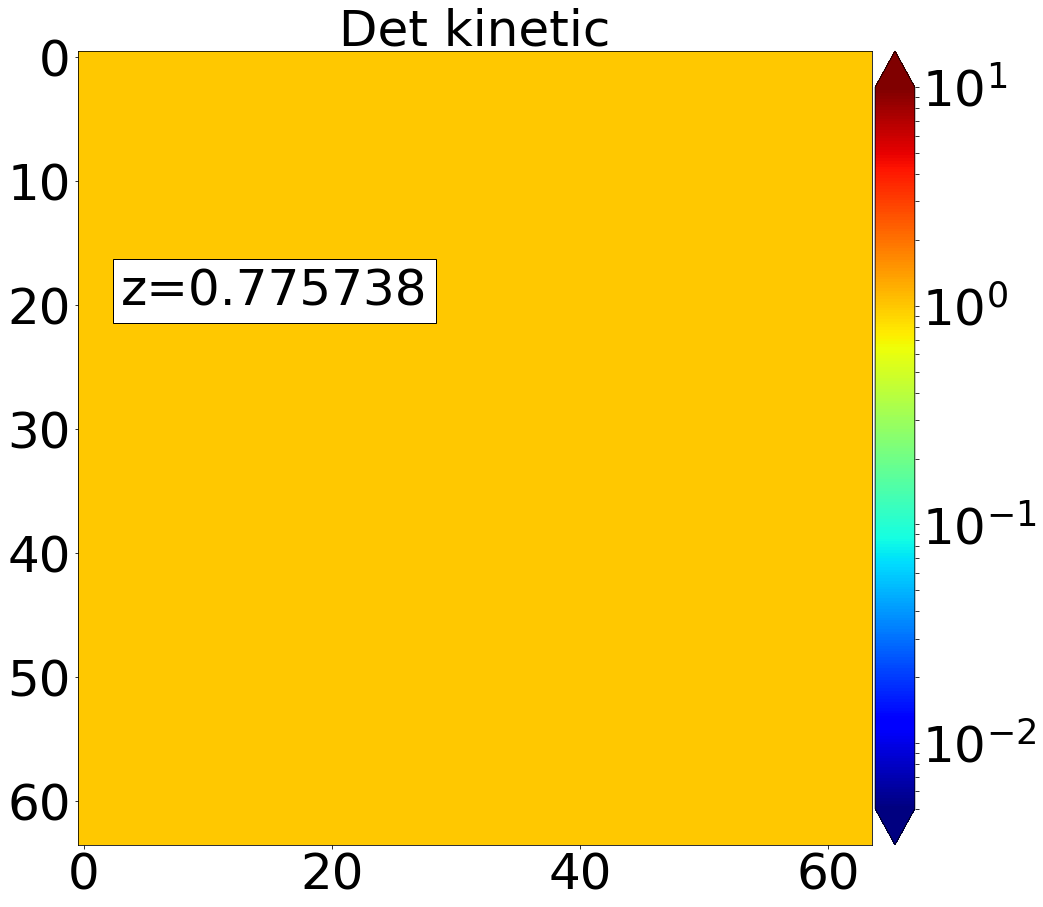

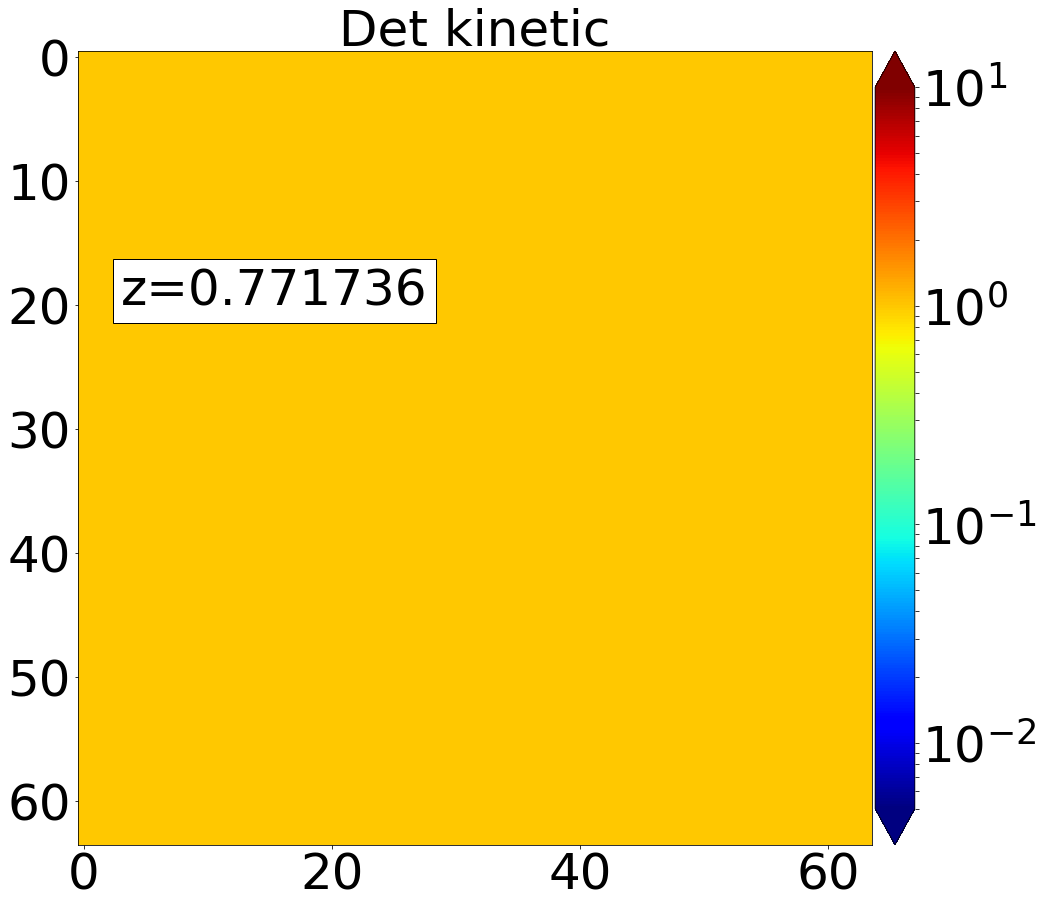

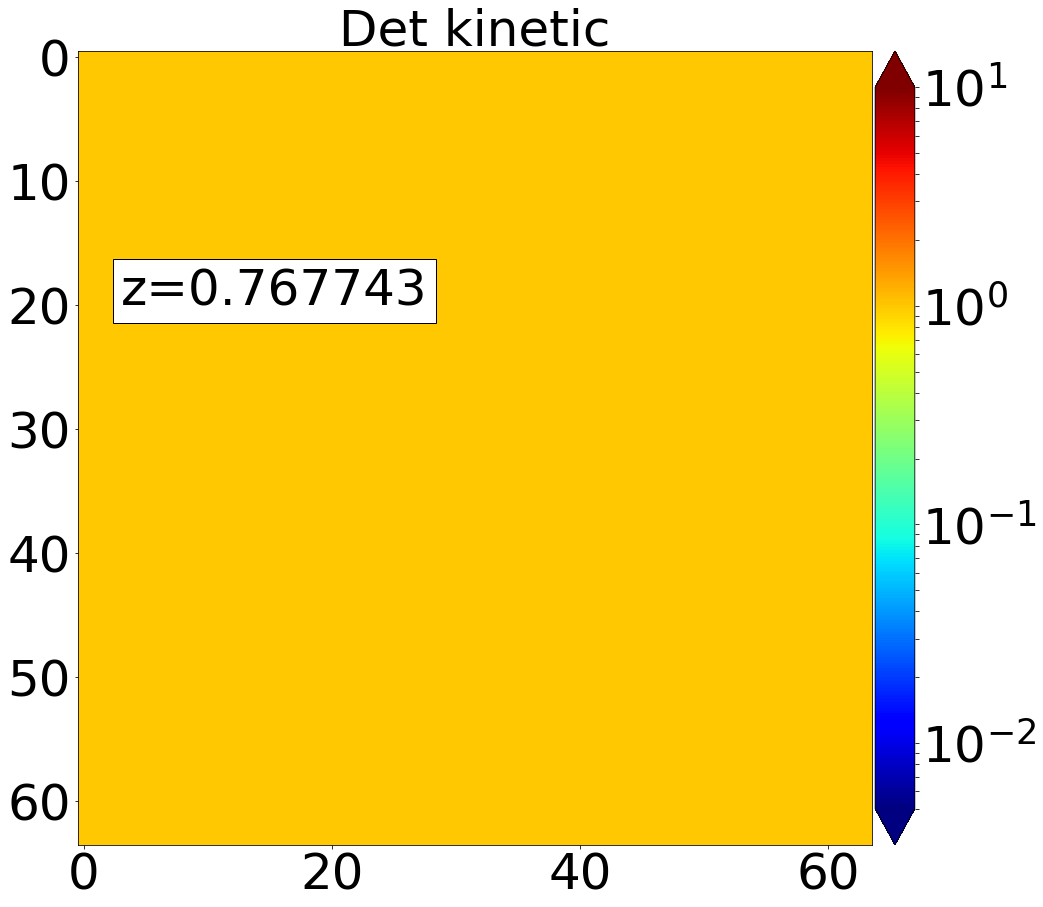

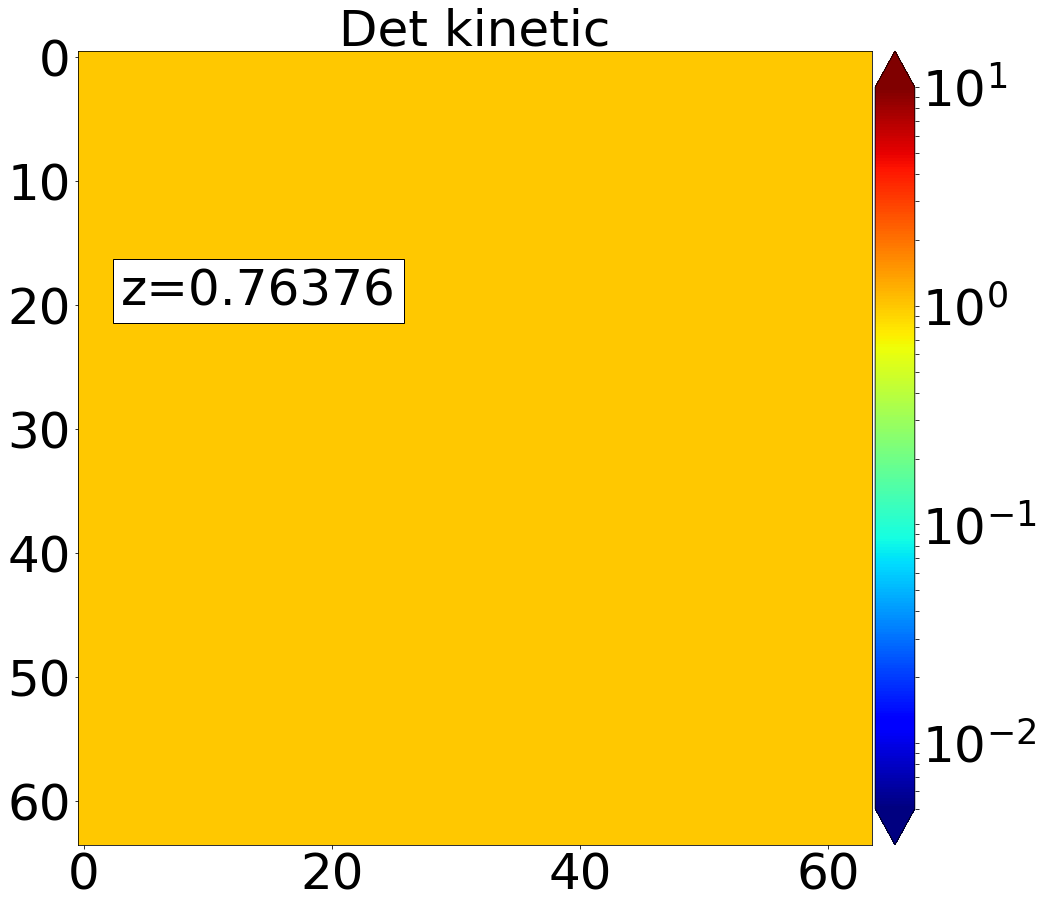

In [25]:

# NORM2 = colors.Normalize(vmin=1.e-1, vmax=1.e1)
NORM2 = colors.LogNorm( vmin=5*10**-3, vmax=1.e1,clip=False)
l=0
j=1

for i in range(1,10):
    fig = plt.figure(figsize=(15,15))
    
    ax2=plt.subplot(111)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 50)
    ax2.tick_params(axis = 'both', which = 'minor', labelsize = 50)
    cs2=plt.imshow((snaps['Det'][str(i)][:,max_secder['pos'][str(j)][0],:]),cmap=plt.cm.get_cmap('jet'),interpolation='gaussian',norm=NORM2)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax2.text(3, 20, 'z='+str(redshifts2[i]), bbox={'facecolor': 'white', 'pad': 8},fontsize=50)
    cbar=plt.colorbar(cs2, cax=cax,extend='both')
    cbar.ax.tick_params(labelsize=50) 
#     ax2.set_xlabel('Mpc/h', fontsize=50)
    ax2.set_title(r'Det kinetic', fontsize=50)
    l=0

    
    
    
plt.show()


In [41]:
snaps['Det'][str(i)][:,max_secder['pos'][str(j)][0],:]

array([[ -19.39277857,  -22.90442074,  -40.30428004, ...,  -30.9878964 ,
         -32.66123056,  -35.21116717],
       [   0.31692819,   14.71758857,   21.24202731, ...,  -13.59808839,
         -18.63250719,  -16.91037492],
       [   3.64541124,   27.51434546,   48.89411894, ...,   -9.02760619,
         -16.91367494,  -12.67805612],
       ..., 
       [ -88.5405426 , -109.51428493, -140.21228624, ...,  -74.23681279,
         -82.0395875 ,  -88.51986028],
       [ -81.52383711, -101.97338949, -126.88365722, ...,  -70.02983761,
         -72.0049967 ,  -84.55006296],
       [ -54.8253016 ,  -74.41912036, -105.90759548, ...,  -55.80838717,
         -55.14377109,  -65.67488275]])